# Snow Depth and Snow Cover Data Exploration 

This tutorial demonstrates how to access and compare coincident snow data across in-situ, airborne, and satellite platforms from NASA's SnowEx, ASO, and xx data sets, respectively. All data are available from the NASA National Snow and Ice Data Center Distributed Active Archive Center, or NSIDC DAAC. 

## Here are the steps you will learn in this snow data notebook:


* Explore the coverage, resolution, and structure of select NSIDC DAAC snow data products, as well as available resources to search and access data.
* Learn how to find and download spatiotemporally coincident data across in-situ, airborne, and satellite observations.
* Learn how to read data into Python from CSV, GeoTIFF, and HDF-EOS formats.
*Learn how to extract and compare raster values at point locations.


___

## Explore snow products and resources


### NSIDC introduction

[The National Snow and Ice Data Center](https://nsidc.org) provides over 1100 data sets covering the Earth's cryosphere and more, all of which are available to the public free of charge. Beyond providing these data, NSIDC creates tools for data access, supports data users, performs scientific research, and educates the public about the cryosphere. 

#### Data Resources

* [NSIDC Data Search](https://nsidc.org/data/search/#keywords=snow)
    * Search NSIDC snow data
* [NSIDC Data Update Announcements](https://nsidc.org/the-drift/data-update/) 
    * News and tips for data users
* [NASA Earthdata Search](http://search.earthdata.nasa.gov/)
    * Search and access data across the NASA Earthdata
* [NASA Worldview](https://worldview.earthdata.nasa.gov/)
    * Interactive interface for browsing full-resolution, global, daily satellite images
    
    
### Snow Today

[Snow Today](https://nsidc.org/snow-today), a collaboration with the University of Colorado's Institute of Alpine and Arctic Research (INSTAAR), provides near-real-time snow analysis for the western United States and regular reports on conditions during the winter season. Snow Today is funded by NASA Hydrological Sciences Program and utilizes data from the
Moderate Resolution Imaging Spectroradiometer (MODIS)instrument and snow station data from the Snow Telemetry (SNOTEL) network by the Natural Resources Conservation Service (NRCS), United States Department of Agriculture (USDA) and the California Department of Water Resources: www.wcc.nrcs.usda.gov/snow.

* Say something about below average snow pack across Western US even with record snowfall in Colorado this year. Could lead into interest in focusing on Grand Mesa...


### Snow-related missions and data sets used in the following steps:

* [SnowEx](https://nsidc.org/data/snowex)
    * SnowEx17 Ground Penetrating Radar Version 2: https://doi.org/10.5067/G21LGCNLFSC5

* [ASO](https://nsidc.org/data/aso)
    * L4 Lidar Snow Depth 50m UTM Grid Version 1: https://doi.org/10.5067/STOT5I0U1WVI
    * ASO L4 Lidar Snow Depth 3m UTM Grid Version 1: https://doi.org/10.5067/KIE9QNVG7HP0
* [MODIS](https://nsidc.org/data/modis)
    * MODIS/Terra Snow Cover Daily L3 Global 500m SIN Grid, Version 6: https://doi.org/10.5067/MODIS/MOD10A1.006


#### Other popular snow products:

* [VIIRS](https://nsidc.org/data/viirs)
    * (VIIRS/NPP CGF Snow Cover Daily L3 Global 375m SIN Grid) V1: https://doi.org/10.5067/VIIRS/VNP10A1F.001



___


## Data Discovery

Using this project in EDSC: 
https://search.earthdata.nasa.gov/projects?projectId=4546673848


SNOTEL data from https://www.wcc.nrcs.usda.gov/snow/



### Import Packages

Get started by importing packages needed to run the following code blocks, including the `tutorial_helper_function` module provided within this repository.

In [1]:
import os
import geopandas as gpd
import fiona
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
import pandas as pd 
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
import pyresample as prs
import requests
import json
import pprint
import getpass
from rasterio.mask import mask


# This is our functions module. We created several helper functions to discover, access, and harmonize the data below.
import tutorial_helper_functions as fn

### Identify area and time of interest

Since our focus is on the Grand Mesa study site of the NASA SnowEx campaign, we'll use that area to search for coincident data across other data products. From the [SnowEx17 Ground Penetrating Radar Version 2](https://doi.org/10.5067/G21LGCNLFSC5) landing page, you can find the rectangular spatial coverage under the Overview tab, or you can draw a polygon over your area of interest in the map under the Download Data tab and export the shape as a geojson file using the Export Polygon icon shown below. An example polygon geojson file is provided in the /Data folder of this repository.   

<img align="left" src="Data-download-polygon-export.png">


#### Create polygon coordinate string

Read in the geojson file as a GeoDataFrame object and simplify and reorder using the shapely package. This will be converted back to a dictionary to be applied as our polygon search parameter. 

Polygon coordinates to be used in search: -108.2352445938561,38.98556907427165,-107.85284607930835,38.978765032966244,-107.85494925720668,39.10596902171742,-108.22772795408136,39.11294532581687,-108.2352445938561,38.98556907427165


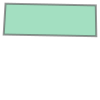

In [3]:
polygon_filepath = str(os.getcwd() + '/Data/nsidc-polygon.json') # Note: A shapefile or other vector-based spatial data format could be substituted here.

gdf = gpd.read_file(polygon_filepath) #Return a GeoDataFrame object

poly = gdf.loc[0] # Label based indexing of GeoDataFrame object to get it into a shapeply geometry object.

# Simplify polygon for complex shapes in order to pass a reasonable request length to CMR. The larger the tolerance value, the more simplified the polygon.
poly = poly.simplify(0.05, preserve_topology=False)

poly = orient(poly, sign=1.0) # Orient counter-clockwise: CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
print('Polygon coordinates to be used in search:', polygon)
poly

#### Set time range

We are interested in accessing files within each data set over the same time range, so we'll start by searching all of 2017.

In [ ]:
temporal = '2017-01-01T00:00:00Z,2017-12-31T23:59:59Z' # Set temporal range

### Create data dictionary 

Create a nested dictionary with each data set short name and version, as well as shared temporal range and polygonal area of interest. 

In [ ]:
data_dict = { 'snowex': {'short_name': 'SNEX17_GPR','version': '2','polygon': polygon,'temporal':temporal},
                'aso': {'short_name': 'ASO_3M_SD','version': '1','polygon': polygon,'temporal':temporal},
             'viirs': {'short_name': 'MOD10A1','version': '6','polygon': polygon,'temporal':temporal}
            }

### Determine how many files exist over this time and area of interest, as well as the average size and total volume of those files

We will use the `granule_info` function to query metadata about each data set and associated files using the [Common Metadata Repository (CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html), which is a high-performance, high-quality, continuously evolving metadata system that catalogs Earth Science data and associated service metadata records. Note that not all NSIDC data can be searched at the file level using CMR, particularly those outside of the NASA DAAC program. 

In [ ]:
for k, v in data_dict.items(): fn.granule_info(data_dict[k])

### Find coincident data

The function above tells us the size of data available for each data set over our time and area of interest, but we want to go a step further and determine what time ranges are coincident based on our bounding box. This `time_overlap` helper function returns a dataframe with file names, dataset_id, start date, and end date for all files that overlap in temporal range across all data sets of interest. 

In [ ]:
df = fn.time_overlap(data_dict)
print(len(df), ' total files returned')
df

## Data Access

We have greatly reduced the number of files needed to compare data across these data sets. For the next steps, we'll focus on a single day: 8 Feb 2017... We'll now collect the data file URLs and download each file.

In [ ]:
# Create new dictionary with fields needed for CMR url search

url_df = df.drop(columns=['start_date', 'end_date','version','dataset_id'])
url_dict = url_df.to_dict('records')

# CMR search variables
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
headers= {'Accept': 'application/json'}

# Create URL list from each df row
urls = []
for i in range(len(url_dict)):
    response = requests.get(granule_search_url, params=url_dict[i], headers=headers)
    results = json.loads(response.content)
    urls.append(fn.cmr_filter_urls(results))
# flatten url list
urls = list(np.concatenate(urls))
urls

This function will download all URLs in the list we gathered in the previous block:

In [ ]:
path = str(os.getcwd() + '/Data')
if not os.path.exists(path):
    os.mkdir(path)
os.chdir(path)
#fn.cmr_download(urls)
fn.cmr_download(urls[0:2])

## Read in SnowEx data and buffer points around Snotel location

SnowEx provided in CSV. We'll use pandas dataframe to pull in data... We'll just pick one day of data and grab the coincident ASO and VIIRS data for this demonstration


We will be focusing on two packages to read in our data:

* [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html)
    * Pandas is built on top of NumPy and provides easy to work with data structures. The pandas dataframe is a 2-D tabular data structure with labeled axes. 
* [Xarray](http://xarray.pydata.org/en/stable/index.html)
    * Designed for multidimensional data. Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays. 

In [ ]:
snowex_path = './SnowEx17_GPR_Version2_Week1.csv' # Define local filepath
df = pd.read_csv(snowex_path, sep='\t') 

According to documentation:

| Variable     | Description                        |
|--------------|------------------------------------|
| GPR          | Short for Ground Penetrating Radar |
| [LineNumber] | Value associated with the raw file |
| [date]       | Date in mmddyy format              |
| TRACE     | Trace number corresponding to the raw data files; each trace is the individual recording of a received signal from the GPR pulse |                 
| LONG      | Longitude                                                                                                                        |
| LAT       | Latitude                                                                                                                         |
| ELEV      | Elevation, in meters (m)                                                                                                         |
| TWTT      | Two-way travel time, in nanoseconds (ns), of the interpreted ground surface reflection                                           |
| THICKNESS | Snow depth, in meters (m)                                                                                                        |
| SWE       | Snow water equivalent (SWE), in millimeters (cm)                                                                                 |
| X         | Easting, calculated from the recorded longitude                                                                                  |
| Y         | Northing, calculated form the recorded latitude                                                                                  |
| UTM_ZONE  | UTM grid zone for the calculated easting and northing                                                                            |

### Convert to time values and extract a single day

Pull out collection date:

In [ ]:
df['date'] = df.collection.str.rsplit('_').str[-1].astype(str)
df.date = pd.to_datetime(df.date, format="%m%d%y")
df = df.sort_values(['date'])
df.head()

Create new dataframe for February 8:

In [ ]:
df_subset = df[df['date'] == '2017-02-08'] 

#### Convert to Geopandas dataframe to provide point geometry:

In [ ]:
# gdf = gpd.GeoDataFrame(
#    df_subset, geometry=gpd.points_from_xy(df_subset.long, df_subset.lat))

# create separate gdf in UTM CRS for buffer distance calculation
#gdf = gpd.GeoDataFrame(df_subset, geometry=gpd.points_from_xy(df_subset.long, df_subset.lat), crs='EPSG:4326')
gdf_utm= gpd.GeoDataFrame(df_subset, geometry=gpd.points_from_xy(df_subset.x, df_subset.y), crs='EPSG:32612')
gdf_utm.head()

### Buffer data around SNOTEL site

Further subset to get within 500 m radius of SNOTEL Mesa Lakes site at 39.05 -108.067 according to https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=622&state=co

First we'll create a new GeoDataFrame with our SNOTEL site location, set to our SnowEx UTM coordinate reference system and create a 500 meter buffer around this point:

In [ ]:
# Create another geodataframe (gdfsel) with the center point for the selection
df_snotel = pd.DataFrame(
    {'SNOTEL Site': ['Mesa Lakes'],
     'Latitude': [39.05],
     'Longitude': [-108.067]})
gdf_snotel = gpd.GeoDataFrame(df_snotel, geometry=gpd.points_from_xy(df_snotel.Longitude, df_snotel.Latitude), crs='EPSG:4326')

gdf_snotel.to_crs('EPSG:32612', inplace=True) # set CRS to UTM 12 N

#create 500 m buffer
buffer = gdf_snotel.buffer(500)

gdf_snotel

Subset SnowEx points to buffer and convert to WGS84 CRS

In [ ]:
# Use the within method of geopandas to find the points within. E.g. gdf_within =
# gdfdata.loc[gdfdata.geometry.within(gdfselbuff.unary_union)]

gdf_buffer = gdf_utm.loc[gdf_utm.geometry.within(buffer.unary_union)]
gdf_buffer = gdf_buffer.to_crs('EPSG:4326')
# print(len(gdf_utm))
# print(len(gdf_buffer))

## Read in Airborne Snow Observatory data

ASO provided as GeoTIFF so we'll use Rasterio. The read() method returns a Numpy array.

In [ ]:
aso_path = './ASO_3M_SD_USCOGM_20170208.tif' # Define local filepath
#aso_path = './ASO_50M_SD/ASO_50M_SD_USCOGM_20170220.tif' # Define local filepath
#aso_qual_path = './ASO_3M_SD/ASO_3M_QF_USCOGM_20170221.tif' # Define local filepath for associated quality file

aso = rasterio.open(aso_path)
# aso_array = aso.read(1, masked=True)
#qual = ASO_3M_QF_USCOGM_20170208.read(1)

### Clip data to SNOTEL buffer

In [ ]:
#buffer = buffer.to_crs(crs=aso.crs.data)
buffer = buffer.to_crs(crs=aso.crs) # convert buffer to CRS of ASO rasterio object

#new_raster = rasterio.mask.mask(aso, buffer, all_touched=False, invert=False, nodata=None, filled=True, crop=False, pad=False, pad_width=0.5, indexes=None)
out_img, out_transform = mask(aso, buffer, crop=True)

out_meta = aso.meta.copy()

epsg_code = int(aso.crs.data['init'][5:])

out_meta.update({"driver": "GTiff", "height": out_img.shape[1], "width": out_img.shape[2], "transform": out_transform, "crs": '+proj=utm +zone=13 +datum=WGS84 +units=m +no_defs'})

out_tif = 'clipped_ASO_3M_SD_USCOGM_20170208.tif'

with rasterio.open(out_tif, 'w', **out_meta) as dest:
    dest.write(out_img)
    
clipped_aso = rasterio.open(out_tif)

#show(clipped, cmap='viridis')

aso_array = clipped_aso.read(1, masked=True)

#clipped_array[clipped_array == -9999.0] = np.nan

## Add ASO data to GeoPandas dataframe

Projection and extent metadata:

In [ ]:
pprint.pprint(clipped_aso.profile)
print('')
print(clipped_aso.bounds)

In [ ]:
# from pyresample import create_area_def
# area_id = 'UTM_13N'
# proj_string = '+proj=utm +zone=13 +datum=WGS84 +units=m +no_defs'
# center = (244510.5, 4323769.5)
# # >>> radius = (5326849.0625, 5326849.0625)
# # >>> resolution = (25067.525, 25067.525)
# create_area_def(area_id, proj_string, center=center)


Define lat lon swath geometry used for interpolation:

In [ ]:
# # 
# snowex_geometry = prs.geometry.SwathDefinition(lons=gdf['long'], lats=gdf['lat'])
# print('snowex geometry: ', snowex_geometry)

snowex_geometry = prs.geometry.SwathDefinition(lons=gdf_buffer['long'], lats=gdf_buffer['lat'])
#print('snowex geometry: ', snowex_geometry)


# Create area definition for ASO
area_id = 'UTM_13N' # area_id: ID of area
description = 'WGS 84 / UTM zone 13N' # description: Description
proj_id = 'UTM_13N' # proj_id: ID of projection (being deprecated)
#projection = 'PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32612"]]'
projection = 'EPSG:32613' # projection: Proj4 parameters as a dict or string
# projection = {'proj': 'utm', 'zone': '13', 'datum': 'WGS84', 'units': 'm'}
#proj_string = '+proj=utm +zone=13 +datum=WGS84 +units=m +no_defs'
#+proj=utm +zone=13 +datum=WGS84 +units=m +no_defs 
width = clipped_aso.width # width: Number of grid columns
height = clipped_aso.height # height: Number of grid rows
# from aso.bounds; area_extent: (lower_left_x, lower_left_y, upper_right_x, upper_right_y)
area_extent = (234081.0, 4326303.0, 235086.0, 4327305.0)
aso_geometry = prs.geometry.AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent)
print ('aso geometry: ', aso_geometry)

### Interpolate ASO values onto SnowEx points

To easily interpolate ASO snow depth to SnowEx points, we can use the `pyresample` library. The `radius_of_influence` parameter determines maximum radius to look for nearest neighbor interpolation.

Masked arrays can be used as data input. In order to have undefined pixels masked out instead of assigned a fill value set fill_value=None when calling the resample_* function.


In [ ]:
# add ASO values to geodataframe
gdf_buffer['aso_snow_depth'] = prs.kd_tree.resample_nearest(aso_geometry, aso_array, snowex_geometry, radius_of_influence=3)

#gdf_buffer[gdf_buffer['aso_snow_depth'] == -9999.0] = np.nan

In [ ]:
gdf_buffer.head()

Add difference column

In [ ]:
gdf_buffer['diff'] = abs(gdf_buffer['Thickness'] - gdf_buffer['aso_snow_depth'])
gdf_buffer.tail()

In [ ]:
gdf_buffer['diff'].median()

## Visualize

GeoTIFF:

In [ ]:
#show(clipped_aso, cmap='viridis')

In [ ]:
gdf_buffer_aso_crs = gdf_buffer.to_crs('EPSG:32613')
#gdf_buffer = gdf_buffer.to_crs('EPSG:32613')

In [ ]:
gdf_buffer_aso_crs.head()

In [ ]:
# plt.scatter(atl07.longitude, atl07.latitude,
#           c=atl07.height_segment_height, vmax=1.5,
#           cmap='Reds', alpha=0.6, s=1)    

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(10, 10))
show(clipped_aso, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf_buffer_aso_crs.plot(column='Thickness', ax=ax, cmap='OrRd', legend=True, cax=cax, legend_kwds=
                        {'label': "Snow Depth (m)",});
#edgecolor='r', facecolor='none',

## Move to GIS

Write to shapefile for GIS applications:


In [ ]:
# gdf_notime = gdf.drop(columns=['date'])
# gdf_notime.to_file('result-08.shp')

gdf_notime = gdf_utm.drop(columns=['date'])
gdf_notime.to_file('snowex-20170208-utm.shp')